## STCML School 2018 via Neural Network

Let's import all necessary libraries.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from IPython.display import clear_output

from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (16, 4)

Fix random state.

In [3]:
RANDOM_STATE = 314159

In [4]:
np.random.seed(RANDOM_STATE)

Read meta data for trainset.

In [5]:
meta = pd.read_csv('./data_v_7_stc/meta/meta.txt', sep='\t',
                   header=None,
                   names=['file_names', 'label'],
                   usecols=[0, 4])
meta.head()

,file_names,label
0,background_0001.wav,background
1,background_0001_time_stretch_0.wav,background
2,background_0001_time_stretch_1.wav,background
3,background_0001_time_stretch_10.wav,background
4,background_0001_time_stretch_11.wav,background


Create the mapping from labels to indices and vice-versa.

In [6]:
index_to_label = ['background', 'bags', 'door', 'keyboard', 'knocking_door', 'ring', 'speech', 'tool', 'unknown']
label_to_index = {label:index for index, label in enumerate(index_to_label)}

In [7]:
meta.label = meta.label.apply(lambda label : label_to_index[label])
meta.head()

,file_names,label
0,background_0001.wav,0
1,background_0001_time_stretch_0.wav,0
2,background_0001_time_stretch_1.wav,0
3,background_0001_time_stretch_10.wav,0
4,background_0001_time_stretch_11.wav,0


Write the function returning valid `.wav` file names between meta data and the corresponding folder.

In [8]:
def getWavFileNames(path_to_fnames, df=None):
    wav_fnames = []
    wav_labels = []
    existing_fnames = list(fname for fname in os.listdir(path_to_fnames) if '.wav' in fname)
    if df is not None:
        existing_fnames = set(existing_fnames)
        for item in tqdm_notebook(df.iterrows(), total=len(df)):
            fname = item[1].file_names
            label = item[1].label
            if fname in existing_fnames:
                wav_fnames.append(fname.strip())
                wav_labels.append(label)
    else:
        for fname in tqdm_notebook(existing_fnames):
            label = fname.split('_')
            if 'knocking' == label[0]:
                label = ['_'.join(label[:2])]
            wav_fnames.append(fname.strip())
            wav_labels.append(label_to_index[label[0]])
            
            
    return wav_fnames, wav_labels

In [9]:
path_to_train = './data_v_7_stc/audio/'
train_wav_fnames, train_wav_labels = getWavFileNames(path_to_train, meta)
train_wav_fnames[:10], train_wav_labels[:10]

A Jupyter Widget

(['background_0001.wav',
  'background_0001_time_stretch_0.wav',
  'background_0001_time_stretch_1.wav',
  'background_0001_time_stretch_10.wav',
  'background_0001_time_stretch_11.wav',
  'background_0001_time_stretch_12.wav',
  'background_0001_time_stretch_13.wav',
  'background_0001_time_stretch_2.wav',
  'background_0001_time_stretch_3.wav',
  'background_0001_time_stretch_4.wav'],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
path_to_test = './data_v_7_stc/test'
test_wav_fnames, test_wav_labels = getWavFileNames(path_to_test)
test_wav_fnames[:10], test_wav_labels[:10]

A Jupyter Widget

(['background_0001.wav',
  'background_0004.wav',
  'background_0009.wav',
  'background_0012.wav',
  'background_0016.wav',
  'background_0018.wav',
  'background_0022.wav',
  'background_0028.wav',
  'background_0031.wav',
  'background_0036.wav'],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's split train data to train and validation sets.

In [11]:
train_wav_fnames, val_wav_fnames, train_wav_labels, val_wav_labels = train_test_split(train_wav_fnames, train_wav_labels, test_size=0.3, random_state=RANDOM_STATE)
len(train_wav_fnames), len(val_wav_fnames)

(7914, 3393)

We will use simple feature extractor (`MFCC`, `MEL SPECTROGRAM`, etc.).

In [12]:
def padAudio(samples, sr=16000):
    if len(samples) >= sr:
        return samples
    else:
        return np.pad(samples, pad_width=(sr - len(samples), 0), mode='constant', constant_values=(0, 0))

In [13]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

In [14]:
def extractFeatures(path, fnames, tlabels, bands=60, frames=41):
    window_size = 512*(frames - 1)
    log_specgrams = []
    labels = []
    spec_num = []
    for fname, label in tqdm_notebook(zip(fnames, tlabels), total=len(fnames)):
        sound_clip, s = librosa.load(os.path.join(path, fname))
        sound_clip = padAudio(sound_clip, sr=s)
        i = 0
        for start, end in windows(sound_clip, window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(signal, n_mels=bands)
                logspec = librosa.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                i += 1
                labels.append(label)
        spec_num.append(i)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams), 1, bands, frames)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=1)
    for i in range(len(features)):
        features[i, 1, ...] = librosa.feature.delta(features[i, 0, ...])
    
    return np.array(features), np.array(labels, dtype=np.int), np.array(spec_num, dtype=np.int)

In [15]:
if os.path.exists('./X_train_2.npy') and os.path.exists('./y_train_2.npy'):
    X_train = np.load('./X_train_2.npy')
    y_train = np.load('./y_train_2.npy')
else:
    X_train, y_train, _ = extractFeatures(path_to_train, train_wav_fnames, train_wav_labels)
    np.save('./X_train_2', X_train)
    np.save('./y_train_2', y_train)

X_train.shape, y_train.shape

((79787, 2, 60, 41), (79787,))

0

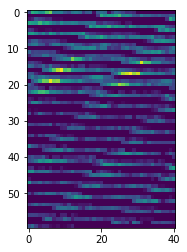

In [16]:
plt.imshow(X_train[3][0]); y_train[3]

In [17]:
if os.path.exists('./X_val_2.npy') and os.path.exists('./y_val_2.npy') and os.path.exists('./c_val_2.npy'):
    X_val = np.load('./X_val_2.npy')
    y_val = np.load('./y_val_2.npy')
    c_val = np.load('./c_val_2.npy')
else:
    X_val, y_val, c_val = extractFeatures(path_to_train, val_wav_fnames, val_wav_labels)
    np.save('./X_val_2', X_val)
    np.save('./y_val_2', y_val)
    np.save('./c_val_2', c_val)

X_val.shape, y_val.shape, c_val.shape

((34564, 2, 60, 41), (34564,), (3393,))

4

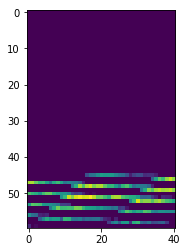

In [18]:
plt.imshow(X_val[3][0]); y_val[3]

Let's define simple CNN using pytorch.

In [19]:
def dataGenerator(data, batch_size=32):
    X, y = data
    n = len(X)
    inds = np.arange(n)
    np.random.shuffle(inds)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        yield X[inds[start:end]], y[inds[start:end]]

In [20]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [21]:
net = nn.Sequential(
    nn.Conv2d(2, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),
    nn.ReLU(inplace=True),
    
    nn.Conv2d(64, 128, 3),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, 3),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2, 2),
    nn.ReLU(inplace=True),
    
    Flatten(),
    
    nn.Linear(512, 512),
    nn.Dropout(0.5),
    nn.ReLU(inplace=True),
    
    nn.Linear(512, 512),
    nn.Dropout(0.5),
    nn.ReLU(inplace=True),
    
    nn.Linear(512, 8),
).cuda()

In [22]:
def calcLoss(inp, target):
    return F.cross_entropy(inp, target)

In [23]:
logits = net(Variable(torch.FloatTensor(next(dataGenerator((X_train, y_train), 1))[0])).cuda())
target = Variable(torch.LongTensor(next(dataGenerator((X_train, y_train), 1))[1])).cuda()
calcLoss(logits, target)

Variable containing:
 1.9810
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Ok, it seems works. Choose Adam optimizer and learn about $30$ epochs.

In [24]:
opt = torch.optim.Adam(net.parameters(), 1e-3)

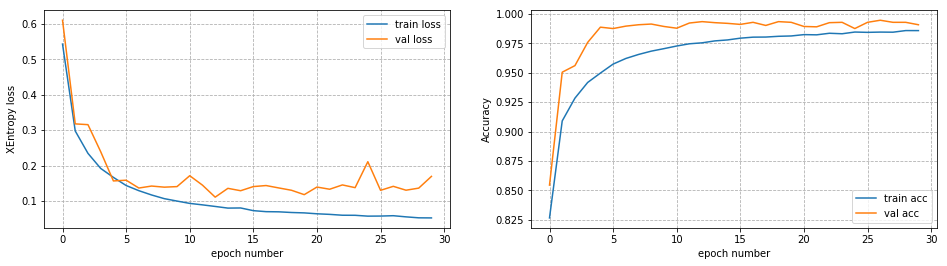

In [25]:
batch_size = 32
epochs = 30

train_loss = []
train_acc = []
val_loss = []
val_acc = []
for epoch in range(epochs):
    net.train()
    train_loss_loc = 0
    train_acc_loc = 0
    i = 0
    for xtr, ytr in tqdm_notebook(dataGenerator((X_train, y_train), batch_size=batch_size), total=len(X_train)//batch_size + 1):
        xtr, target = Variable(torch.FloatTensor(xtr)).cuda(), Variable(torch.LongTensor(ytr)).cuda()
        logits = net(xtr)
        loss = calcLoss(logits, target)
        train_loss_loc += loss.cpu().data.numpy()[0]
        train_acc_loc += (ytr == F.softmax(logits, dim=1).cpu().data.numpy().argmax(1)).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        i += 1
    train_loss.append(train_loss_loc/i)
    train_acc.append(train_acc_loc/i)

    net.eval()
    start = 0
    val_loss_loc = 0
    val_acc_loc = 0
    y_pred = []
    yval = []
    for num in tqdm_notebook(c_val):
        yval.append(y_val[start])
        xval = Variable(torch.FloatTensor(X_val[start:start + num]), volatile=True).cuda()
        target = Variable(torch.LongTensor(y_val[start:start + num]), volatile=True).cuda()
        logits = net(xval)
        loss = calcLoss(logits, target)
        val_loss_loc += loss.cpu().data.numpy()[0]
        probas = F.softmax(logits, dim=1).cpu().data.numpy()
        y_pred.append(probas.mean(0))
        start += num
    y_pred = np.array(y_pred)
    yval = np.array(yval)
    val_loss.append(val_loss_loc/len(c_val))
    val_acc.append((y_pred.argmax(1) == yval).mean())

    clear_output(True)
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.legend()
    plt.xlabel('epoch number')
    plt.ylabel('XEntropy loss')
    plt.grid(ls='--')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.plot(val_acc, label='val acc')
    plt.legend()
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy')
    plt.grid(ls='--')

    plt.show()

In [26]:
if os.path.exists('./X_test_2.npy') and os.path.exists('./y_test_2.npy') and os.path.exists('./c_test_2.npy'):
    X_test = np.load('./X_test_2.npy')
    y_test = np.load('./y_test_2.npy')
    c_test = np.load('./c_test_2.npy')
else:
    X_test, y_test, c_test = extractFeatures(path_to_test, test_wav_fnames, test_wav_labels)
    np.save('./X_test_2', X_test)
    np.save('./y_test_2', y_test)
    np.save('./c_test_2', c_test)

X_test.shape, y_test.shape, c_test.shape

((6754, 2, 60, 41), (6754,), (610,))

In [27]:
net.eval()
start = 0
test_loss_loc = 0
test_acc_loc = 0
y_pred = []
ytest = []
for num in tqdm_notebook(c_test):
    ytest.append(y_test[start])
    xtest = Variable(torch.FloatTensor(X_test[start:start + num]), volatile=True).cuda()
    target = Variable(torch.LongTensor(y_test[start:start + num]), volatile=True).cuda()
    logits = net(xtest)
    loss = calcLoss(logits, target)
    test_loss_loc += loss.cpu().data.numpy()[0]
    probas = F.softmax(logits, dim=1).cpu().data.numpy()
    y_pred.append(probas.mean(0))
    start += num
y_pred = np.array(y_pred)
ytest = np.array(ytest)

test_loss_loc/len(c_test), (y_pred.argmax(1) == ytest).mean(), (y_pred.argmax(1) == ytest)[:-137].mean()

A Jupyter Widget

(7.0617992109589931, 0.70983606557377055, 0.91543340380549687)

Finetune on the whole trainset.

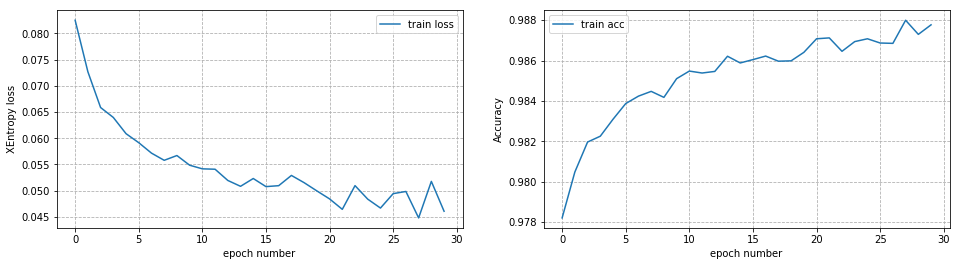

In [31]:
batch_size = 32
epochs = 30

train_loss_ft = []
train_acc_ft = []
for epoch in range(epochs):
    net.train()
    train_loss_loc = 0
    train_acc_loc = 0
    i = 0
    for xtr, ytr in tqdm_notebook(dataGenerator((np.vstack([X_train, X_val]), np.hstack([y_train, y_val])),
                                                batch_size=batch_size),
                                  total=(len(X_train) + len(X_val))//batch_size + 1):
        xtr, target = Variable(torch.FloatTensor(xtr)).cuda(), Variable(torch.LongTensor(ytr)).cuda()
        logits = net(xtr)
        loss = calcLoss(logits, target)
        train_loss_loc += loss.cpu().data.numpy()[0]
        train_acc_loc += (ytr == F.softmax(logits, dim=1).cpu().data.numpy().argmax(1)).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        i += 1
    train_loss_ft.append(train_loss_loc/i)
    train_acc_ft.append(train_acc_loc/i)

    clear_output(True)
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_ft, label='train loss')
    plt.legend()
    plt.xlabel('epoch number')
    plt.ylabel('XEntropy loss')
    plt.grid(ls='--')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_ft, label='train acc')
    plt.legend()
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy')
    plt.grid(ls='--')

    plt.show()

In [32]:
net.eval()
start = 0
test_loss_loc = 0
test_acc_loc = 0
y_pred = []
ytest = []
for num in tqdm_notebook(c_test):
    ytest.append(y_test[start])
    xtest = Variable(torch.FloatTensor(X_test[start:start + num]), volatile=True).cuda()
    target = Variable(torch.LongTensor(y_test[start:start + num]), volatile=True).cuda()
    logits = net(xtest)
    loss = calcLoss(logits, target)
    test_loss_loc += loss.cpu().data.numpy()[0]
    probas = F.softmax(logits, dim=1).cpu().data.numpy()
    y_pred.append(probas.mean(0))
    start += num
y_pred = np.array(y_pred)
ytest = np.array(ytest)

test_loss_loc/len(c_test), (y_pred.argmax(1) == ytest).mean(), (y_pred.argmax(1) == ytest)[:-137].mean()

A Jupyter Widget

(8.5381629154143077, 0.69999999999999996, 0.90274841437632136)

Write results to file.

In [33]:
with open('./result_nn30.txt', 'w') as out:
    for fname, probas in zip(test_wav_fnames, y_pred):
        out.write('\t'.join([fname, str(np.max(probas)), str(index_to_label[np.argmax(probas)])]))
        out.write('\n')